# Projet simulation logicielle
* *Rhouch Oussama*
* *Cherki Inssaf*

<img src="https://github.com/oussamarhouch/Projet-Audio/blob/main/figure/model%20based.png?raw=1" alt="CS" style="width: 750px;"/>

## Importing libraries

In [11]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from scipy.io.wavfile import write
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import warnings
import random
import logging
torch.cuda.empty_cache()
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.signal import spectrogram
from IPython.display import Audio

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Performing preprocessing on the data

##### Unzip the data

In [3]:
# own IDE
zip_file_paths = ['data/data_part1.zip', 'data/data_part2.zip', 'data/data_part3.zip', 'data/data_part4.zip']

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# os.makedirs("data", exist_ok=True)

# zip_file_paths = ['/content/drive/My Drive/audio_project/data_part1.zip',
#     '/content/drive/My Drive/audio_project/data_part2.zip',
#     '/content/drive/My Drive/audio_project/data_part3.zip',
#     '/content/drive/My Drive/audio_project/data_part4.zip']

In [4]:
for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(".")

##### Data folders

In [5]:
noise_folder = "data/noise/"
clean_folder = "data/clean/dev-clean"
output_folder = "data/noisy/"
denoising_folder = "data/denoising/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(denoising_folder, exist_ok=True)

### Clean audio data

##### Load clean audio data

In [6]:
target_duration = 5 # 5sec

In [7]:
# Get the list of clean files
clean_path = []
for folder in os.listdir(clean_folder):
    folder_path = os.path.join(clean_folder, folder)
    if os.path.isdir(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    clean_path.append(file_path)

In [8]:
clean_data = []
for clean_file in clean_path[:20]:
    s, sr = librosa.load(clean_file, sr=16000)
    target_length = target_duration * sr
    s = librosa.util.fix_length(s, size = target_length)
    clean_data.append(s)

len(clean_data)


20

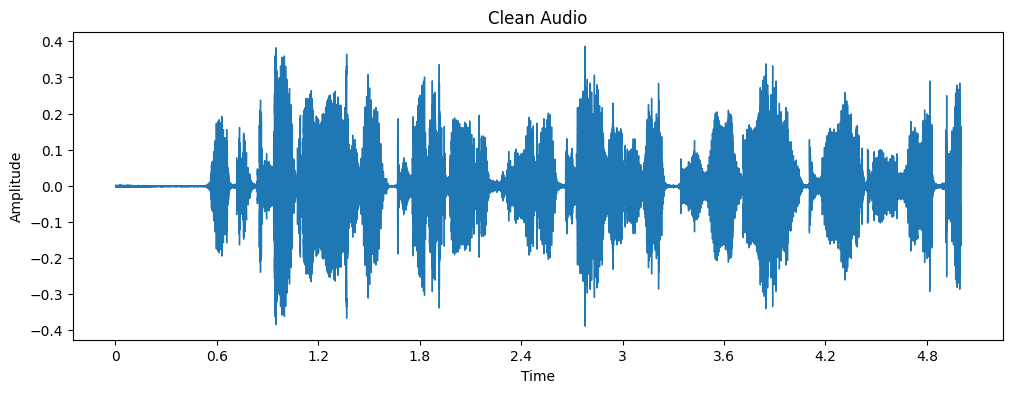

In [9]:
s_rate = 16000

plt.figure(figsize=(12, 4))
librosa.display.waveshow(clean_data[0], sr=s_rate)
plt.title('Clean Audio')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [12]:
write("clean.wav", s_rate, s)

Audio("clean.wav")

In [13]:
# normalize the clean audio
s_norm = preprocessing.normalize([s])

# Fourier transform
s_stft = librosa.stft(s_norm[0])

# convert to dB
s_stft_db = librosa.amplitude_to_db(abs(s_stft))

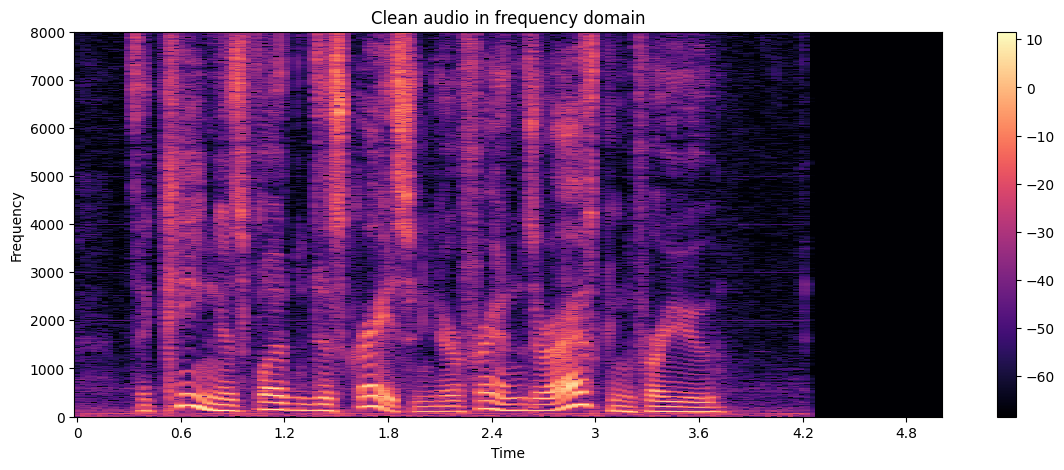

In [14]:
# plot the clean audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(s_stft_db, sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Clean audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [15]:
# Get the list of noise files
noise_file = ""
if os.path.isdir(noise_folder):
        for root, dirs, files in os.walk(noise_folder):
            for file in files:
                if file.endswith(".wav"):
                    noise_file = os.path.join(root, file)

noise_file

'data/noise/babble_16k.wav'

In [16]:
# load noise data
u, ur = librosa.load(noise_file, sr=16000)

target_length = target_duration * ur
u = librosa.util.fix_length(u, size = target_length)

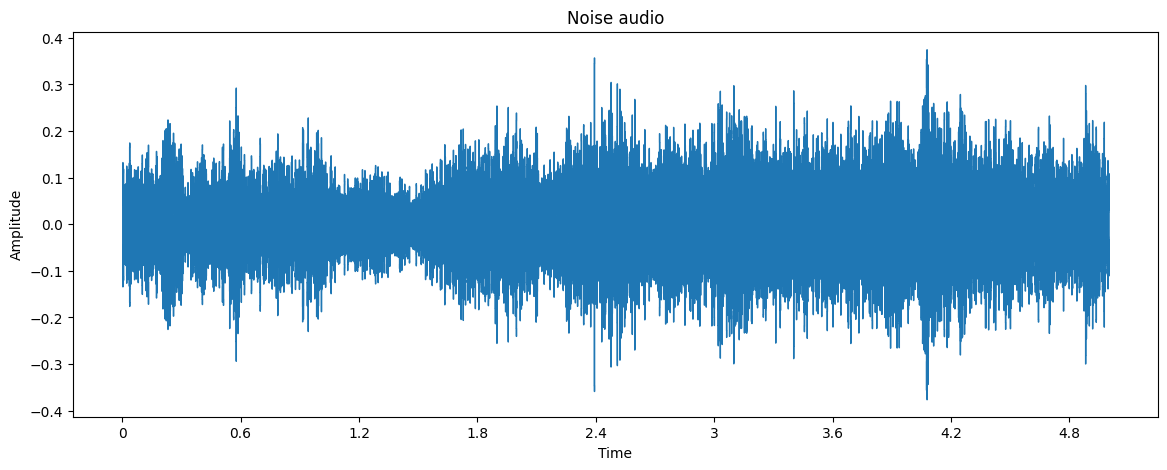

In [17]:
# Plot the noise audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(u, sr=ur)
plt.title("Noise audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [18]:
# normalize the clean audio
u_norm = preprocessing.normalize([u])

# Fourier transform
u_stft = librosa.stft(u_norm[0])

# convert to dB
u_stft_db = librosa.amplitude_to_db(abs(u_stft))

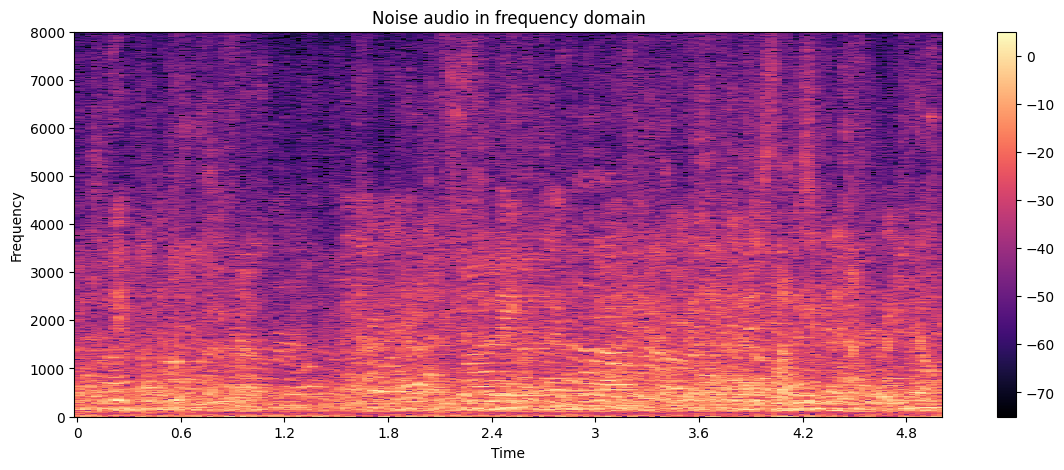

In [19]:
# plot the noise audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(u_stft_db, sr=ur, x_axis="time", y_axis="hz")
plt.title("Noise audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [20]:
# mix the clean and noise audio
rsb = 6
alpha = 10**(-rsb/10)

x = s + alpha * u[:len(s)]
x = x.astype(np.float32)

In [22]:
# save the mixed audio
write(os.path.join('', "mixed.wav"), s_rate, x)

Audio("mixed.wav")

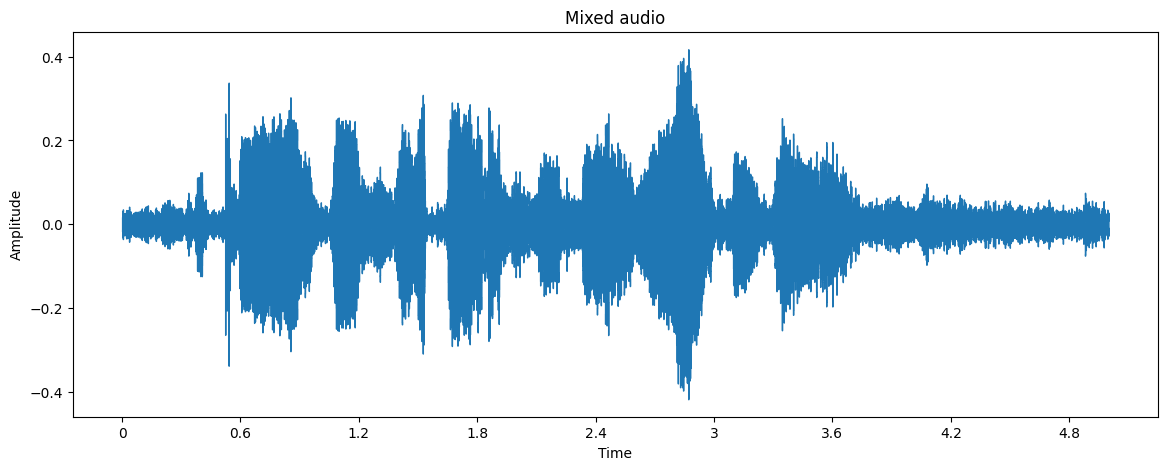

In [23]:
# plot the noisy audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=s_rate)
plt.title("Mixed audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [24]:
# Fourier transform of the noisy audio
x_stft = librosa.stft(x)

# convert to dB
x_stft_db = librosa.amplitude_to_db(abs(x_stft))

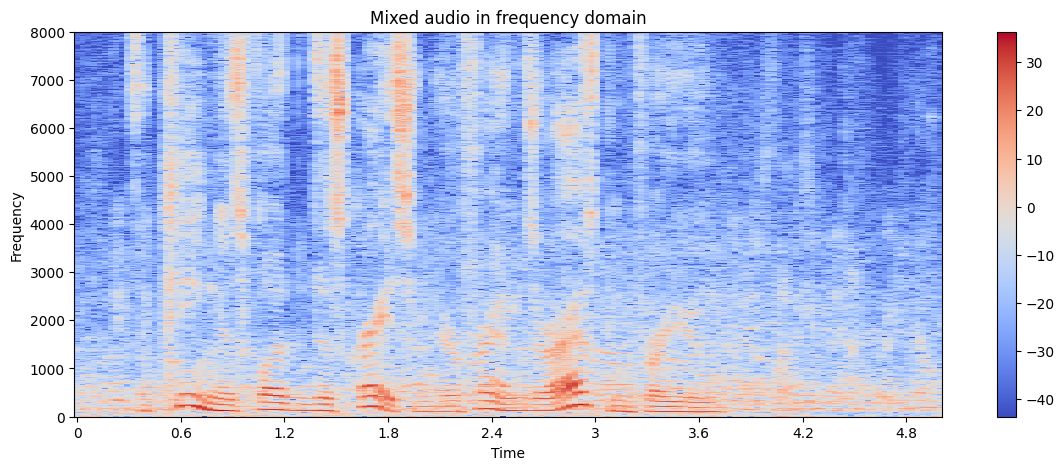

In [25]:
# plot the noisy audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_stft_db, sr=sr, x_axis="time", y_axis="hz")
plt.title("Mixed audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [26]:
s_stft_10s = []
x_stft_10s = []
for i in range(0, len(s_stft)):
    if i % 10 == 0:
        s_stft_10s.append(s_stft[i:i+10])
        x_stft_10s.append(x_stft[i:i+10])

In [27]:
U, _ = librosa.magphase(u_stft)
rms = librosa.feature.rms(S=U)

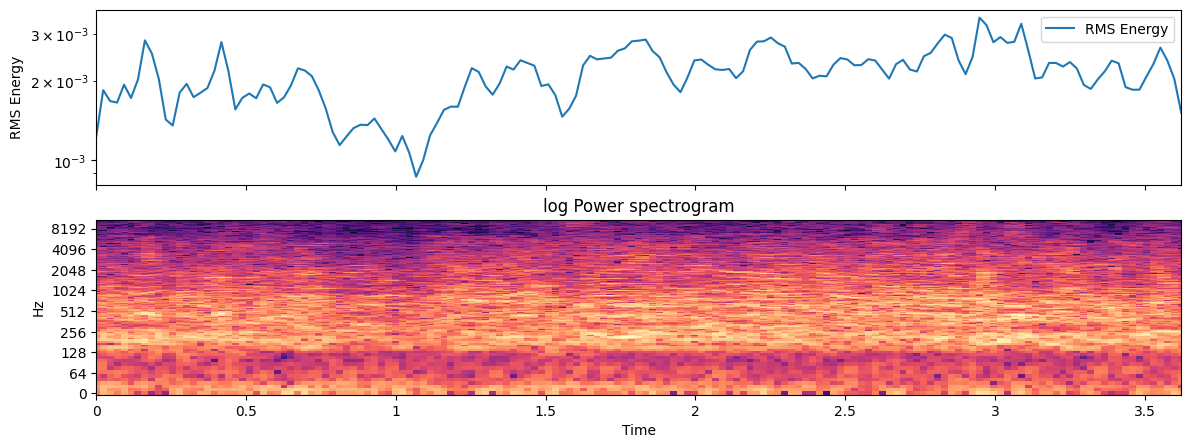

In [28]:
fig, ax = plt.subplots(figsize=(14, 5), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[], xlim=[times.min(), times.max()], ylabel='RMS Energy')
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(U), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
plt.show()

# Preprocessing

In [52]:
class AudioPreprocessor:
    def __init__(self, clean_files, noise_file):
        self.clean_files = clean_files
        self.noise_file = noise_file
        self.clean_data = []
        self.noisy_spec = []
        self.clean_spec = []

    def mix_audio_frequency_domain(self, clean_audio, noise_audio, snr_db):
        # Fourier Transform
        clean_fft = np.fft.fft(clean_audio)
        noise_fft = np.fft.fft(noise_audio[:len(clean_audio)])

        # Calculate the power of the signals in the frequency domain
        clean_power = np.sum(np.abs(clean_fft) ** 2) / len(clean_fft)
        noise_power = np.sum(np.abs(noise_fft) ** 2) / len(noise_fft)

        # Calculate the scaling factor for noise to achieve desired SNR
        alpha = np.sqrt(clean_power / (noise_power * 10 ** (snr_db / 10)))

        # Mix in the frequency domain
        mixed_fft = clean_fft + alpha * noise_fft

        # Inverse Fourier Transform to get back to time domain
        mixed_audio = np.fft.ifft(mixed_fft)
        return np.real(mixed_audio)

    def process_files(self):
        target_duration = 5
        noise_audio, sr_noise = sf.read(self.noise_file)

        for clean_file in self.clean_files:
            clean_audio, sr = sf.read(clean_file)
            # save the clean audio
            write(os.path.join(denoising_folder, os.path.basename(clean_file)), sr, clean_audio)

            if sr != sr_noise:
                # Resample noise to match the clean file's sample rate
                noise_audio_resampled = librosa.resample(noise_audio, sr_noise, sr)
            else:
                noise_audio_resampled = noise_audio

            # Adjust the length of the clean audio to the target duration
            target_length = target_duration * sr
            clean_audio = clean_audio[:target_length]

            self.clean_data.append(clean_audio)

            # Loop or truncate the noise audio to match the clean audio length
            if len(noise_audio_resampled) < len(clean_audio):
                repetitions = int(np.ceil(len(clean_audio) / len(noise_audio_resampled)))
                noise_audio_resampled = np.tile(noise_audio_resampled, repetitions)[:len(clean_audio)]
            else:
                noise_audio_resampled = noise_audio_resampled[:len(clean_audio)]

            # Mix with -6 dB SNR in frequency domain
            noisy_audio = self.mix_audio_frequency_domain(clean_audio, noise_audio_resampled, -6)

            # Generate Spectrograms for both noisy and clean audio
            frequencies, _, Sxx_noisy = spectrogram(noisy_audio, fs=sr)
            _, _, Sxx_clean = spectrogram(clean_audio, fs=sr)

            # Convert to decibels
            noisy_spectrogram = 10 * np.log10(Sxx_noisy)
            clean_spectrogram = 10 * np.log10(Sxx_clean)

            # Append to respective lists
            self.noisy_spec.append(noisy_spectrogram)
            self.clean_spec.append(clean_spectrogram)
            
            # Find the maximum size among all spectrograms
            max_size = max(spec.shape[1] for spec in self.noisy_spec + self.clean_spec)

            # Pad all spectrograms to have the same size
            self.noisy_spec = [np.pad(spec, ((0, 0), (0, max_size - spec.shape[1])), mode='constant') for spec in self.noisy_spec]
            self.clean_spec = [np.pad(spec, ((0, 0), (0, max_size - spec.shape[1])), mode='constant') for spec in self.clean_spec]
    
    def get_dataset(self, batch_size=32, test_split=0.2):
        # Convert lists to numpy arrays
        X = np.array(self.noisy_spec)
        y = np.array(self.clean_spec)

        # Calculate the number of samples for the test set
        total_samples = X.shape[0]
        test_size = int(total_samples * test_split)

        # Shuffle the dataset
        indices = np.arange(total_samples)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Split the data into training and test sets
        X_train = X_shuffled[test_size:]
        y_train = y_shuffled[test_size:]
        X_test = X_shuffled[:test_size]
        y_test = y_shuffled[:test_size]

        # Create TensorFlow datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_dataset = test_dataset.batch(batch_size)

        return train_dataset, test_dataset

In [53]:
preprocessor = AudioPreprocessor(clean_path[:5], noise_file)
preprocessor.process_files()

([array([[ -58.87801909,  -57.90339164,  -74.33919487, ...,  -71.51594391,
           -69.13846494,  -64.89104156],
         [ -52.19638154,  -49.70671891,  -57.97147542, ...,  -56.90670489,
           -56.97904108,  -52.79070434],
         [ -48.07347126,  -49.31051641,  -39.52979015, ...,  -44.06737832,
           -44.05118468,  -47.79963669],
         ...,
         [ -90.67673558,  -96.21094937,  -96.09504246, ...,  -83.32536012,
           -81.82793385,  -78.63053881],
         [ -91.55698904, -106.78962139,  -98.00254937, ...,  -85.9143195 ,
           -77.32505884,  -96.02628809],
         [ -95.60012478,  -96.05866238,  -93.68406106, ..., -112.86855687,
          -115.8058599 , -107.7702703 ]]),
  array([[ -56.99073382,  -55.90258121,  -71.68707692, ...,    0.        ,
             0.        ,    0.        ],
         [ -49.96203216,  -47.63417892,  -55.77239844, ...,    0.        ,
             0.        ,    0.        ],
         [ -46.18637617,  -47.38235808,  -37.61603303, .

In [54]:
train_dataset, test_dataset = preprocessor.get_dataset()

TypeError: AudioPreprocessor.get_dataset() missing 2 required positional arguments: 'noisy_spec' and 'clean_spec'

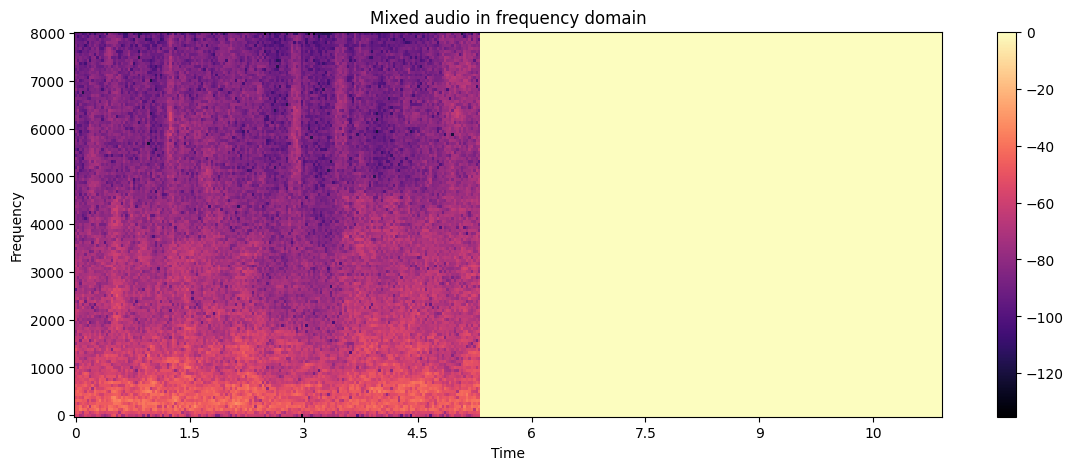

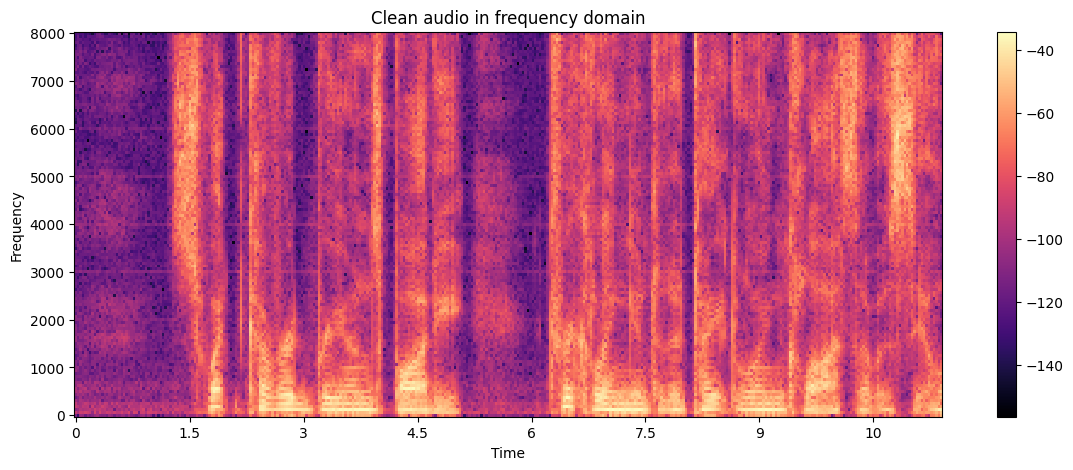

In [36]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(train_dataset.take(1).as_numpy_iterator().next()[0][0], sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Mixed audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

plt.figure(figsize=(14, 5))
librosa.display.specshow(train_dataset.take(1).as_numpy_iterator().next()[1][0], sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Clean audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [40]:
# return one clean spectrogram and one noisy spectrogram
def get_sample():
    for noisy, clean in train_dataset.take(1):
        return noisy[0], clean[0]
    
noisy_sample, clean_sample = get_sample()

# get back to time domain
noisy_sample = librosa.db_to_amplitude(noisy_sample)
clean_sample = librosa.db_to_amplitude(clean_sample)

# inverse Fourier transform
noisy_sample = librosa.istft(noisy_sample)
clean_sample = librosa.istft(clean_sample)

# save the noisy and clean audio
write(os.path.join('', "noisy_sample.wav"), s_rate, noisy_sample)
write(os.path.join('', "clean_sample.wav"), s_rate, clean_sample)

Audio("noisy_sample.wav")

Audio("clean_sample.wav")

In [131]:
def extract_features_labels(dataset):
    features, labels = [], []
    for feature, label in dataset:
        features.append(feature.numpy())
        labels.append(label.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features_labels(train_dataset)
X_test, y_test = extract_features_labels(test_dataset)

In [135]:
print("Shape of X_train:", X_train.shape)

Shape of X_train: (3,)


In [134]:
model = models.Sequential([
    # Encoder
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),

    # Decoder
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

model.summary()


ValueError: Input 0 of layer "conv2d_34" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)

In [127]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [128]:
# Assuming model is your TensorFlow/Keras model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10


3/3 [==============================] - 3s 393ms/step - loss: 7985.9634 - val_loss: 7775.4541
Epoch 2/10
3/3 [==============================] - 1s 293ms/step - loss: 7985.9634 - val_loss: 7775.4541
Epoch 3/10
3/3 [==============================] - 1s 285ms/step - loss: 7985.9624 - val_loss: 7775.4541
Epoch 4/10
3/3 [==============================] - 1s 282ms/step - loss: 7985.9634 - val_loss: 7775.4541
Epoch 5/10
3/3 [==============================] - 1s 287ms/step - loss: 7985.9634 - val_loss: 7775.4541
Epoch 6/10
3/3 [==============================] - 1s 283ms/step - loss: 7985.9634 - val_loss: 7775.4541
Epoch 7/10
3/3 [==============================] - 1s 287ms/step - loss: 7985.9624 - val_loss: 7775.4541
Epoch 8/10
3/3 [==============================] - 1s 292ms/step - loss: 7985.9634 - val_loss: 7775.4541
Epoch 9/10
3/3 [==============================] - 1s 288ms/step - loss: 7985.9634 - val_loss: 7775.4541
Epoch 10/10
3/3 [==============================] - 1s 286ms/step - loss: 79

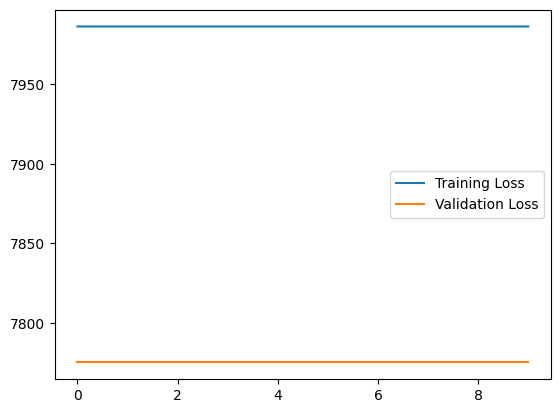

In [129]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [130]:
# To evaluate on the test set
loss, accuracy = model.evaluate(test_dataset)

1/1 [==============================] - 0s 83ms/step - loss: 7775.4541


TypeError: cannot unpack non-iterable float object